In [ ]:
# Spotify Tracks — what makes a song “work”?

# I wanted to see what actually lines up with popularity on Spotify — energy, danceability, loudness, tempo.  
# Data lives in PostgreSQL (Docker). I run short SQL queries via Python and plot straight from the DB. The goal is simple visuals + clear takeaways.

In [33]:
# setup
import os, pandas as pd 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import seaborn as sns
import numpy as np

plt.rcParams["figure.dpi"] = 140
plt.rcParams["axes.grid"] = True

load_dotenv()
engine = create_engine(os.getenv("DATABASE_URL"))

def q(sql, params=None):
    with engine.begin() as con:
        return pd.read_sql(text(sql), con, params=params)

In [9]:
# Analyse average track features by subgenre
sql = """
SELECT
    st.playlist_subgenre,
    COUNT(*) AS n,
    AVG(st.danceability)::float AS avg_danceability,
    AVG(st.energy)::float AS avg_energy,
    AVG(st.valence)::float AS avg_valence,
    AVG(st.tempo)::float AS avg_tempo,
    AVG(st.loudness)::float AS avg_loudness_db
FROM staging_tracks st
GROUP BY st.playlist_subgenre
ORDER BY n DESC;
"""

df_genre = q(sql)
df_genre.head()

,playlist_subgenre,n,avg_danceability,avg_energy,avg_valence,avg_tempo,avg_loudness_db
0,southern hip hop,3166,0.712627,0.681145,0.554645,118.906871,-6.959708
1,indie poptimism,3094,0.625849,0.637175,0.456226,118.012863,-7.162278
2,neo soul,2956,0.644409,0.540869,0.511833,110.135174,-8.378233
3,progressive electro house,2920,0.653855,0.810262,0.385516,126.290612,-5.801666
4,electro house,2832,0.704478,0.802486,0.429057,125.197134,-5.857287


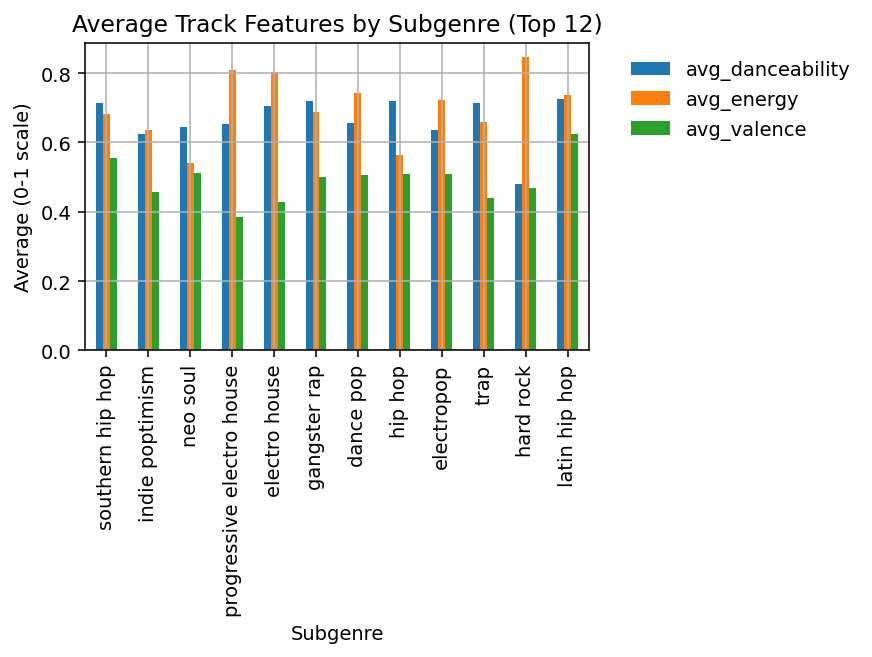

In [13]:
# Plot average features for top 12 subgenres
top = df_genre.sort_values("n", ascending=False).head(12).copy()

ax = top.plot(
    x="playlist_subgenre",
    y=["avg_danceability", "avg_energy", "avg_valence"],
    kind="bar",
)
ax.set_title("Average Track Features by Subgenre (Top 12)")
ax.set_xlabel("Subgenre")
ax.set_ylabel("Average (0-1 scale)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.savefig("../figures/subgenre_feature_profile.png")
plt.show()



In [15]:
# Analyse track popularity percentiles by subgenre
sql = """
SELECT 
    st.playlist_subgenre,
    COUNT(*) AS n,
    PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY st.track_popularity) AS p50_pop,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY st.track_popularity) AS p75_pop,
    PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY st.track_popularity) AS p90_pop
FROM staging_tracks st
WHERE st.playlist_subgenre IS NOT NULL AND st.playlist_subgenre <> ''
GROUP BY st.playlist_subgenre
ORDER BY n DESC;
"""

df_pop = q(sql)
df_pop.head()

,playlist_subgenre,n,p50_pop,p75_pop,p90_pop
0,southern hip hop,3166,37.0,52.0,63.0
1,indie poptimism,3094,44.0,57.0,66.0
2,neo soul,2956,31.0,47.0,58.0
3,progressive electro house,2920,24.0,41.0,51.0
4,electro house,2832,37.0,48.0,57.0


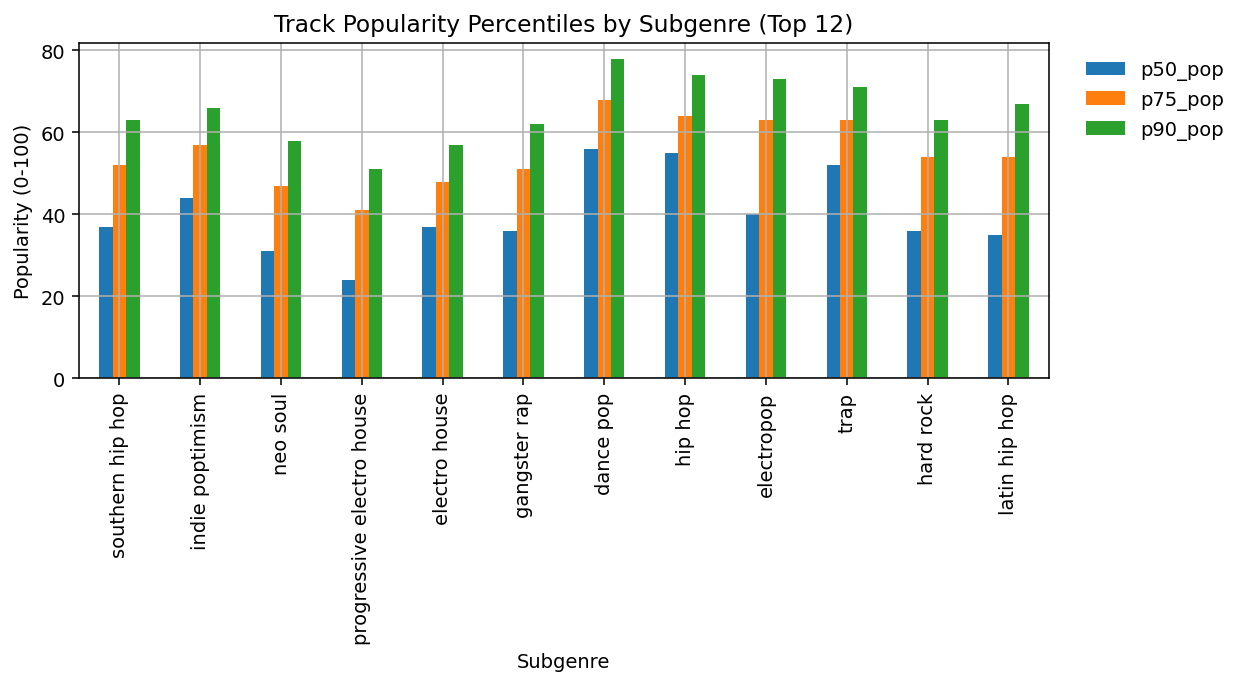

In [ ]:
# Plot track popularity percentiles for top 12 subgenres
top = df_pop.sort_values("n", ascending=False).head(12)

ax = top.plot(
    x="playlist_subgenre",
    y=["p50_pop", "p75_pop", "p90_pop"],
    kind="bar",
    figsize=(9,5)
)
ax.set_title("Track Popularity Percentiles by Subgenre (Top 12)")
ax.set_xlabel("Subgenre")
ax.set_ylabel("Popularity (0-100)")
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.savefig("../figures/subgenre_popularity_distribution.png", bbox_inches="tight")
plt.show()



In [ ]:
# Analyse track key and mode distribution
sql = """
SELECT key, mode, COUNT(*) AS n
FROM tracks
GROUP BY key, mode
ORDER BY n DESC;
"""

df_keys = q(sql)

def key_names():
    return ["C", "C#/Db", "D", "D#/Eb", "E", "F", "F#/Gb", "G", "G#/Ab", "A", "A#/Bb", "B"]

def key_label(row):
    try:
        base = key_names()[int(row["key"]) % 12]
        mode_name = "major" if int(row["mode"]) == 1 else "minor"
        return f"{base} {mode_name}"
    except Exception:
        return "Unknown"
    
df_keys["label"] = df_keys.apply(key_label, axis=1)
df_keys.head()




,key,mode,n,label
0,1,1,2274,C#/Db major
1,0,1,2207,C major
2,7,1,2127,G major
3,2,1,1920,D major
4,11,0,1614,B minor


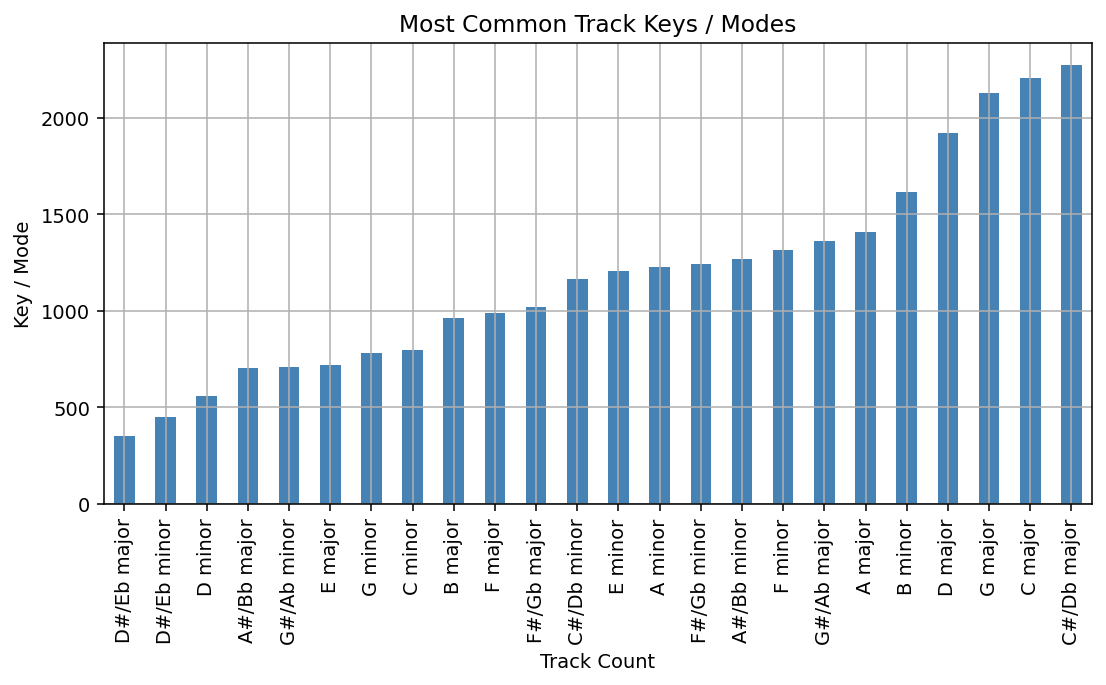

In [ ]:
# Plot track key and mode distribution
ax = df_keys.sort_values("n").plot(
    x="label",
    y="n",
    kind="bar",
    figsize=(8,5),
    legend=False,
    color="steelblue"
)
ax.set_title("Most Common Track Keys / Modes")
ax.set_xlabel("Track Count")
ax.set_ylabel("Key / Mode")
plt.tight_layout()
plt.savefig("../figures/keys_modes_overall.png", bbox_inches="tight")
plt.show()

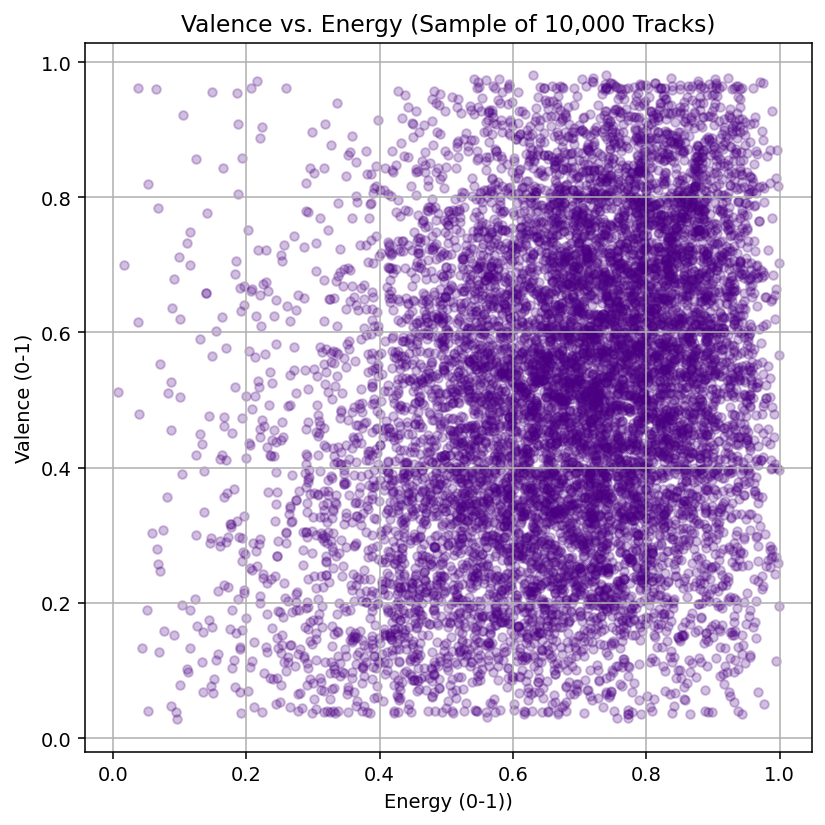

In [19]:
# Scatter plot of valence vs. energy
sql = """
SELECT valence, energy
FROM staging_tracks
WHERE valence IS NOT NULL AND energy IS NOT NULL
LIMIT 10000;
"""
df_scatter = q(sql)

ax = df_scatter.plot.scatter(
    x="energy",
    y="valence",
    alpha=0.25,
    figsize=(6,6),
    color="indigo"
)
ax.set_title("Valence vs. Energy (Sample of 10,000 Tracks)")
ax.set_xlabel("Energy (0-1))")
ax.set_ylabel("Valence (0-1)")
plt.tight_layout()
plt.savefig("../figures/scatter_valence_vs_energy.png", bbox_inches="tight")
plt.show()

In [20]:
# Top 20 artists by average track popularity (min 10 tracks)
sql = """
WITH agg AS (
    SELECT
        st.track_artist,
        COUNT(*) AS n,
        AVG(st.track_popularity)::float AS avg_pop
    FROM staging_tracks st
    WHERE st.track_artist IS NOT NULL AND st.track_artist <> ''
    GROUP BY st.track_artist 
)
SELECT * FROM agg
WHERE n >= 10
ORDER BY avg_pop DESC
LIMIT 20;
"""
df_art = q(sql)
df_art

,track_artist,n,avg_pop
0,DaBaby,12,83.666667
1,Roddy Ricch,14,83.428571
2,Harry Styles,18,81.777778
3,YNW Melly,14,81.571429
4,Billie Eilish,52,76.961538
5,Lewis Capaldi,18,76.888889
6,Alec Benjamin,12,76.833333
7,Dimelo Flow,10,76.800000
8,Rich Music LTD,12,76.500000
9,Twenty One Pilots,16,76.125000


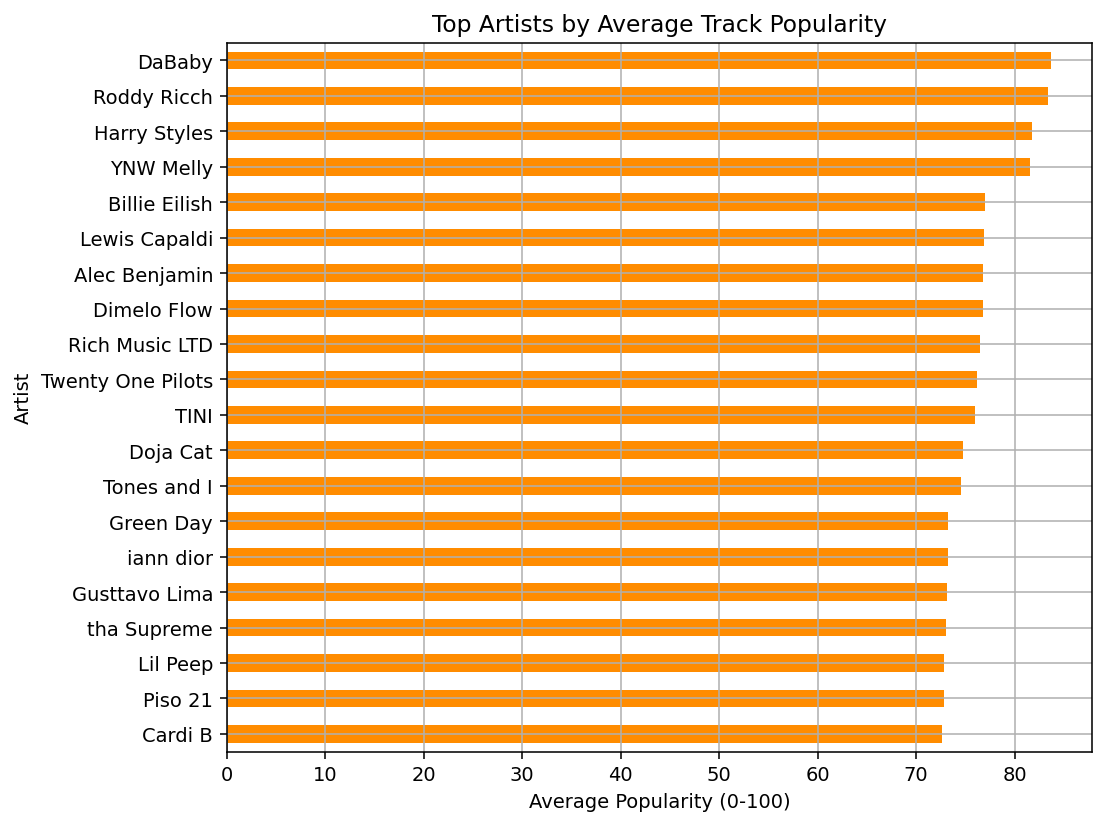

In [ ]:
# Plot top 20 artists by average track popularity
ax = df_art.sort_values("avg_pop").plot(
    x="track_artist",
    y="avg_pop",
    kind="barh",
    figsize=(8, 6),
    color="darkorange",
    legend=False
)
ax.set_title("Top Artists by Average Track Popularity")
ax.set_xlabel("Average Popularity (0-100)")
ax.set_ylabel("Artist")
plt.tight_layout()
plt.savefig("../figures/top_artists_avg_pop.png", bbox_inches="tight")
plt.show()

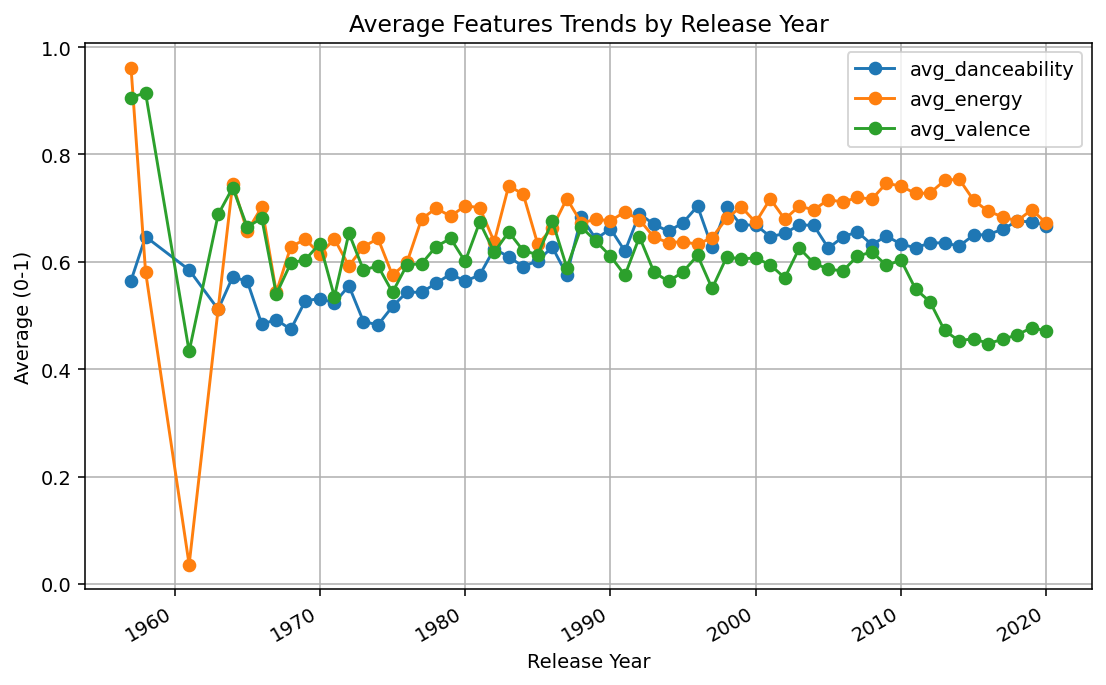

In [23]:
# Analyse average features by release year
sql = """
SELECT DATE_TRUNC('year', release_date) AS year,
    COUNT(*) AS n,
    AVG(danceability)::float AS avg_danceability,
    AVG(energy)::float AS avg_energy,
    AVG(valence)::float AS avg_valence
FROM tracks
WHERE release_date IS NOT NULL
GROUP BY 1  
ORDER BY 1;
"""

df_year = q(sql)

ax = df_year.plot(
    x="year",
    y=["avg_danceability", "avg_energy", "avg_valence"],
    kind="line",
    marker="o",
    figsize=(8,5)
)
ax.set_title("Average Features Trends by Release Year")
ax.set_xlabel("Release Year")
ax.set_ylabel("Average (0-1)")
plt.tight_layout()
plt.savefig("../figures/trends_by_release_year.png", bbox_inches="tight")
plt.show()

C:\Users\David\AppData\Local\Temp\ipykernel_30756\2933103929.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tempo_counts = (df.groupby(['playlist_subgenre', 'tempo_bucket'])


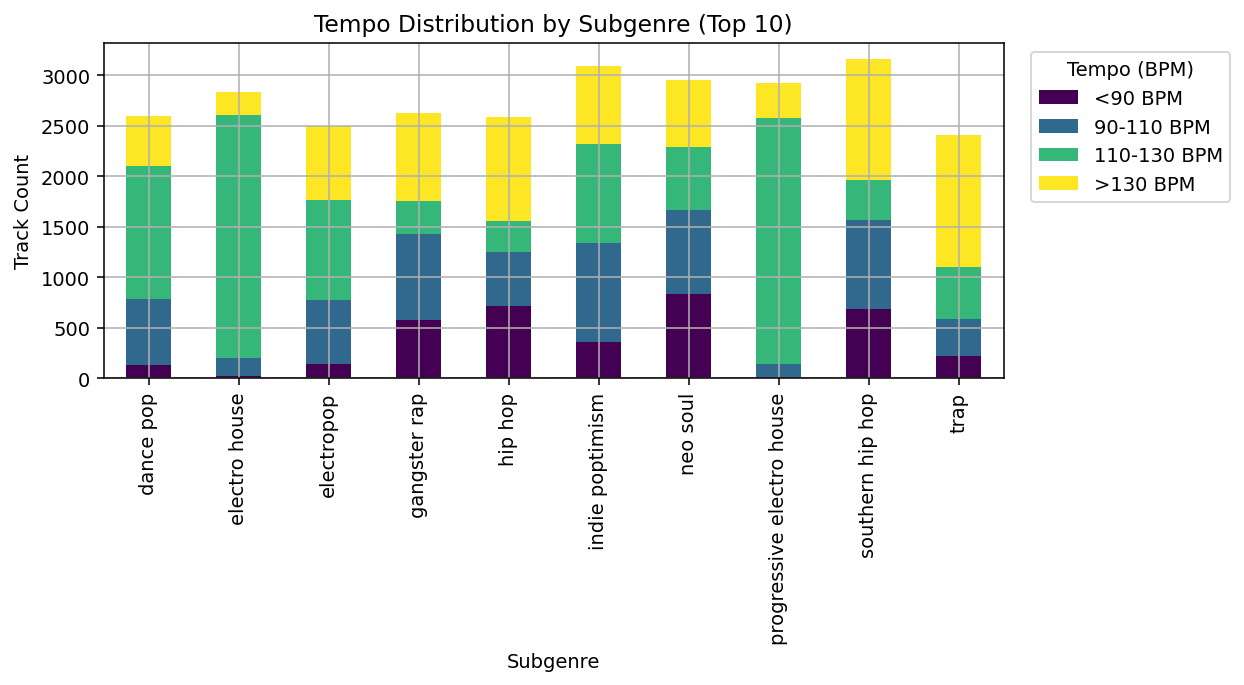

In [24]:
# Analyse tempo buckets by subgenre
sql = """
SELECT playlist_subgenre, tempo
FROM staging_tracks
WHERE playlist_subgenre IS NOT NULL AND tempo IS NOT NULL;
"""
df = q(sql)

bins = [0, 90, 110, 130, 1000]
labels = ['<90 BPM', '90-110 BPM', '110-130 BPM', '>130 BPM']
df['tempo_bucket'] = pd.cut(df['tempo'], bins=bins, labels=labels)

tempo_counts = (df.groupby(['playlist_subgenre', 'tempo_bucket'])
                .size().reset_index(name='count'))
top = df['playlist_subgenre'].value_counts().head(10).index
pivot = tempo_counts[tempo_counts['playlist_subgenre'].isin(top)].pivot(index='playlist_subgenre', columns='tempo_bucket', values='count').fillna(0)

pivot.plot(kind='bar', stacked=True, figsize=(9,5), colormap='viridis')
plt.title('Tempo Distribution by Subgenre (Top 10)')
plt.xlabel('Subgenre')
plt.ylabel('Track Count')
plt.legend(title='Tempo (BPM)', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.savefig('../figures/tempo_buckets_by_subgenre.png', bbox_inches='tight')
plt.show()

<Figure size 1260x840 with 0 Axes>

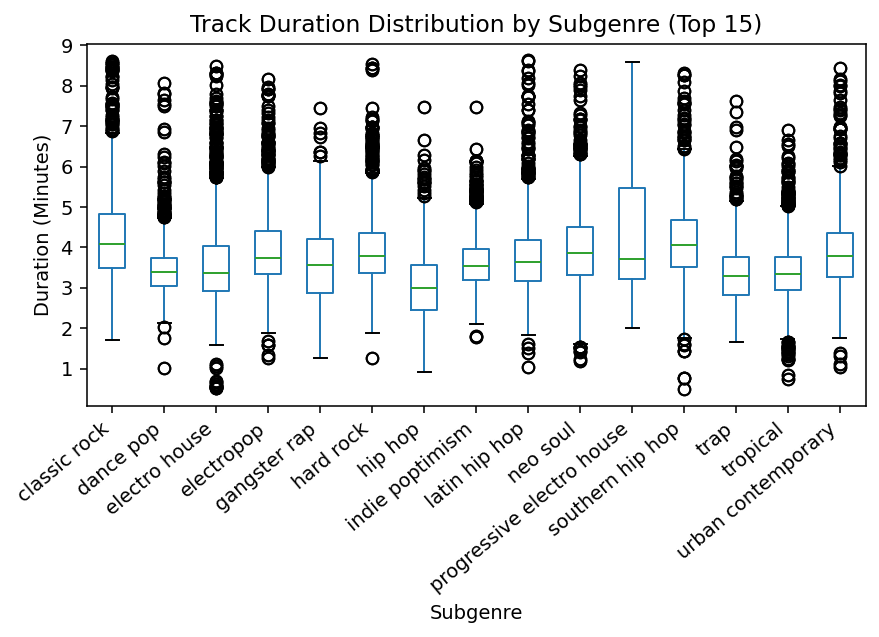

In [28]:
# Analyse track duration distribution by subgenre
sql = """
SELECT playlist_subgenre, duration_ms
FROM staging_tracks
WHERE duration_ms IS NOT NULL
AND playlist_subgenre IS NOT NULL
AND playlist_subgenre <> '';
"""
df = q(sql)
df['duration_min'] = df['duration_ms'] / 60000

top = df['playlist_subgenre'].value_counts().head(15).index
subset = df[df['playlist_subgenre'].isin(top)]

plt.figure(figsize=(9,6))
subset.boxplot(column='duration_min', by='playlist_subgenre', grid=False)
plt.title('Track Duration Distribution by Subgenre (Top 15)')
plt.suptitle('')
plt.xlabel('Subgenre')
plt.ylabel('Duration (Minutes)')
plt.xticks(rotation=40, ha='right')
plt.tight_layout()
plt.savefig('../figures/duration_distribution_by_subgenre.png', bbox_inches='tight')
plt.show()

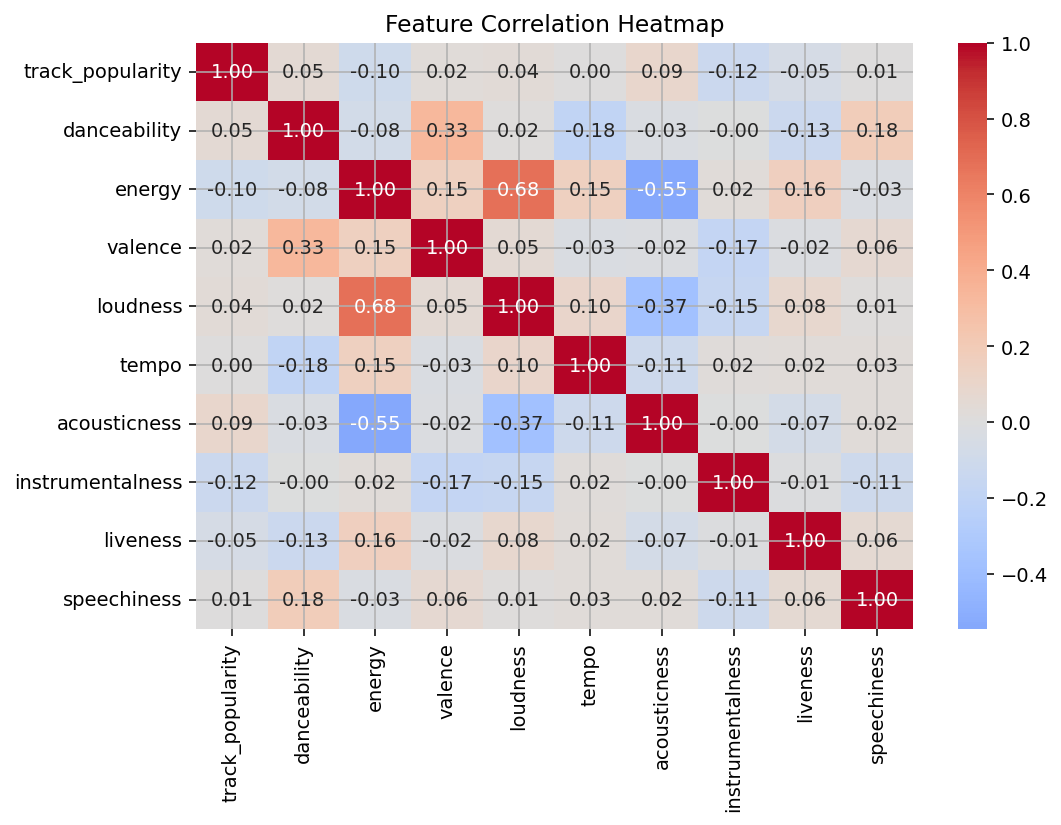

In [31]:
# Feature correlation heatmap
sql = """
SELECT track_popularity, danceability, energy, valence, loudness, tempo, acousticness, instrumentalness, liveness, speechiness
FROM staging_tracks;
"""
df = q(sql).dropna()

corr = df.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("../figures/feature_correlation_heatmap.png", bbox_inches="tight")
plt.show()

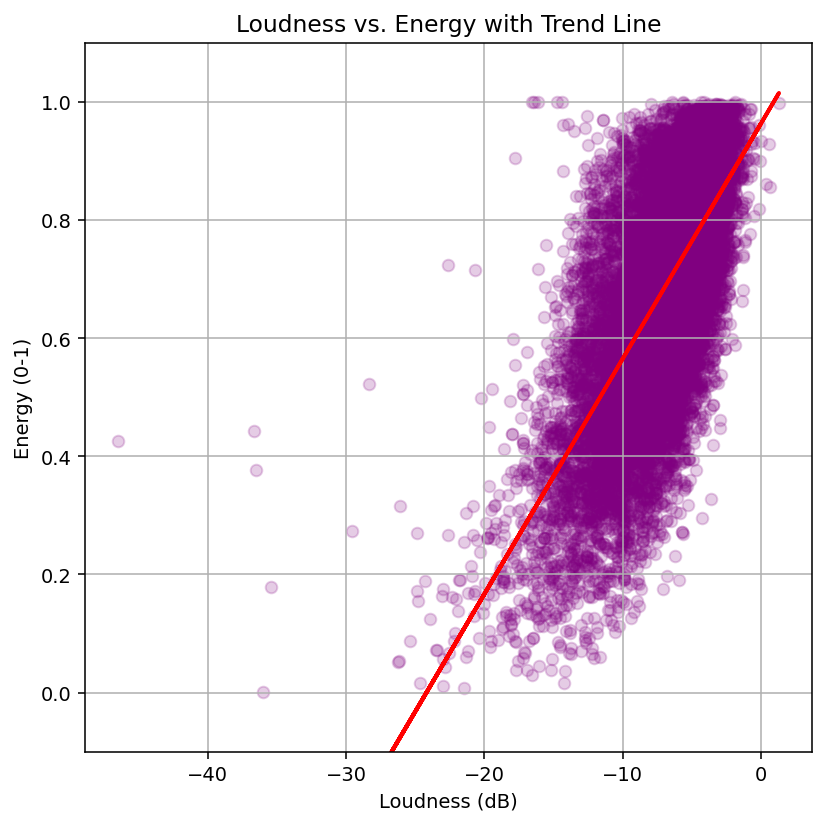

In [38]:
# Scatter plot of loudness vs. energy with trend line
sql = """
SELECT loudness, energy
FROM staging_tracks
WHERE loudness IS NOT NULL AND energy IS NOT NULL
LIMIT 20000;
"""
df = q(sql)

plt.figure(figsize=(6,6))
plt.scatter(df['loudness'], df['energy'], alpha=0.2, color='purple')
coef = np.polyfit(df['loudness'], df['energy'], 1)
plt.plot(df['loudness'], np.polyval(coef, df['loudness']), color='red', lw=2)
plt.ylim(-0.1, 1.1)
plt.title("Loudness vs. Energy with Trend Line")
plt.xlabel("Loudness (dB)")
plt.ylabel("Energy (0-1)")
plt.tight_layout()
plt.savefig("../figures/loudness_vs_energy.png", bbox_inches="tight")
plt.show()

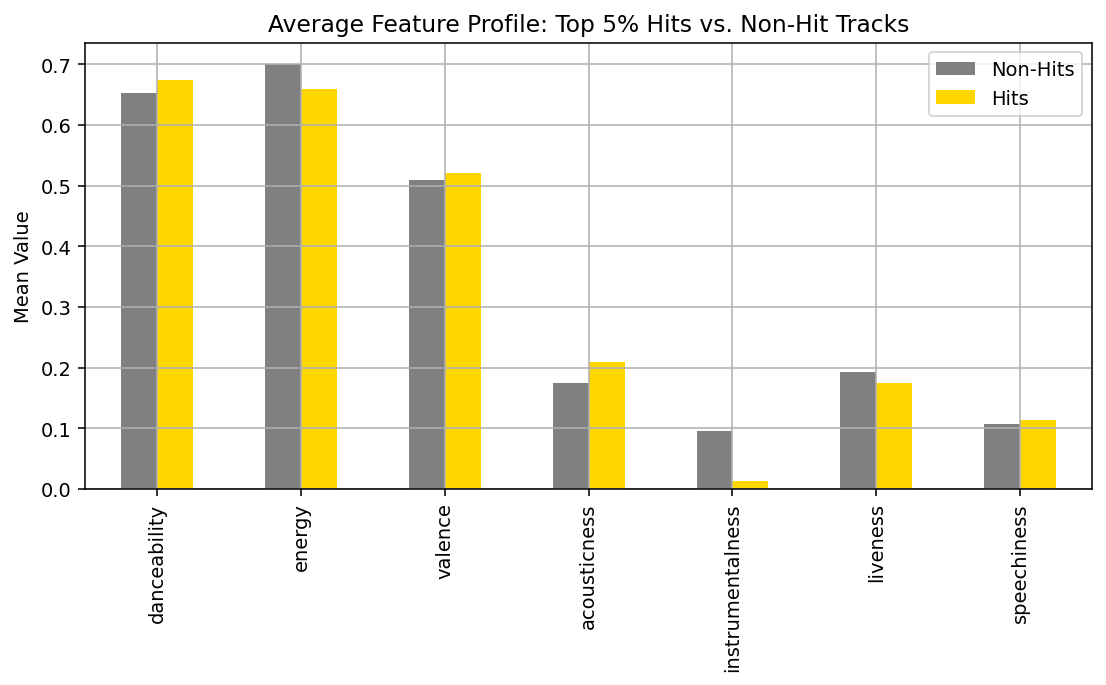

In [ ]:
# Compare average features of top 5% hits vs. non-hits
sql = "SELECT * FROM staging_tracks WHERE track_popularity IS NOT NULL;"
df = q(sql)
p95 = np.percentile(df['track_popularity'], 95)
df['is_hit'] = df['track_popularity'] >= p95

features = ['danceability', 'energy', 'valence', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']
avg_features = df.groupby('is_hit')[features].mean().T

avg_features.plot(kind='bar', figsize=(8,5), color=['grey','gold'])
plt.title("Average Feature Profile: Top 5% Hits vs. Non-Hit Tracks")
plt.ylabel("Mean Value")
plt.legend(['Non-Hits', 'Hits'])
plt.tight_layout()
plt.savefig("../figures/hit_vs_nonhit_feature_profile.png", bbox_inches="tight")
plt.show()

C:\Users\David\AppData\Local\Temp\ipykernel_30756\1304199173.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_pop = df.groupby('bucket')['track_popularity'].mean().reset_index()


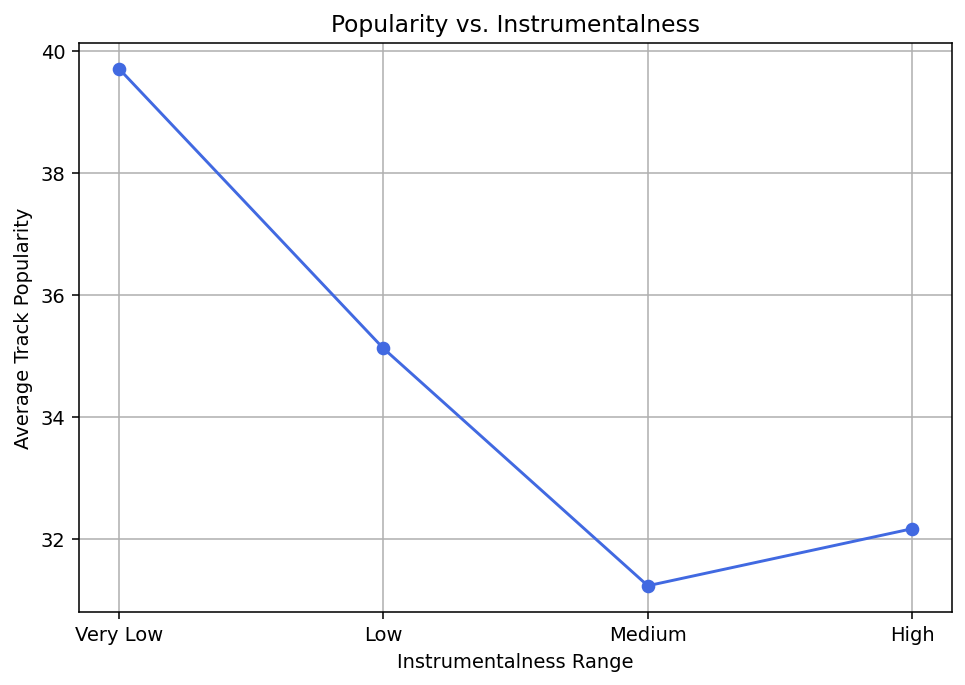

In [43]:
# Analyse instrumentalness vs. track popularity
sql = """
SELECT instrumentalness, track_popularity
FROM staging_tracks
WHERE instrumentalness IS NOT NULL AND track_popularity IS NOT NULL;
"""
df = q(sql)

df['bucket'] = pd.cut(df['instrumentalness'], bins=[0,0.01,0.2,0.8,1.0], labels=['Very Low', 'Low', 'Medium', 'High'])
avg_pop = df.groupby('bucket')['track_popularity'].mean().reset_index()

plt.figure(figsize=(7,5)) 
plt.plot(avg_pop['bucket'], avg_pop['track_popularity'], marker='o', color='royalblue')
plt.title('Popularity vs. Instrumentalness')
plt.ylabel('Average Track Popularity')
plt.xlabel('Instrumentalness Range')
plt.tight_layout()
plt.savefig('../figures/instrumentalness_vs_popularity.png', bbox_inches='tight')
plt.show()

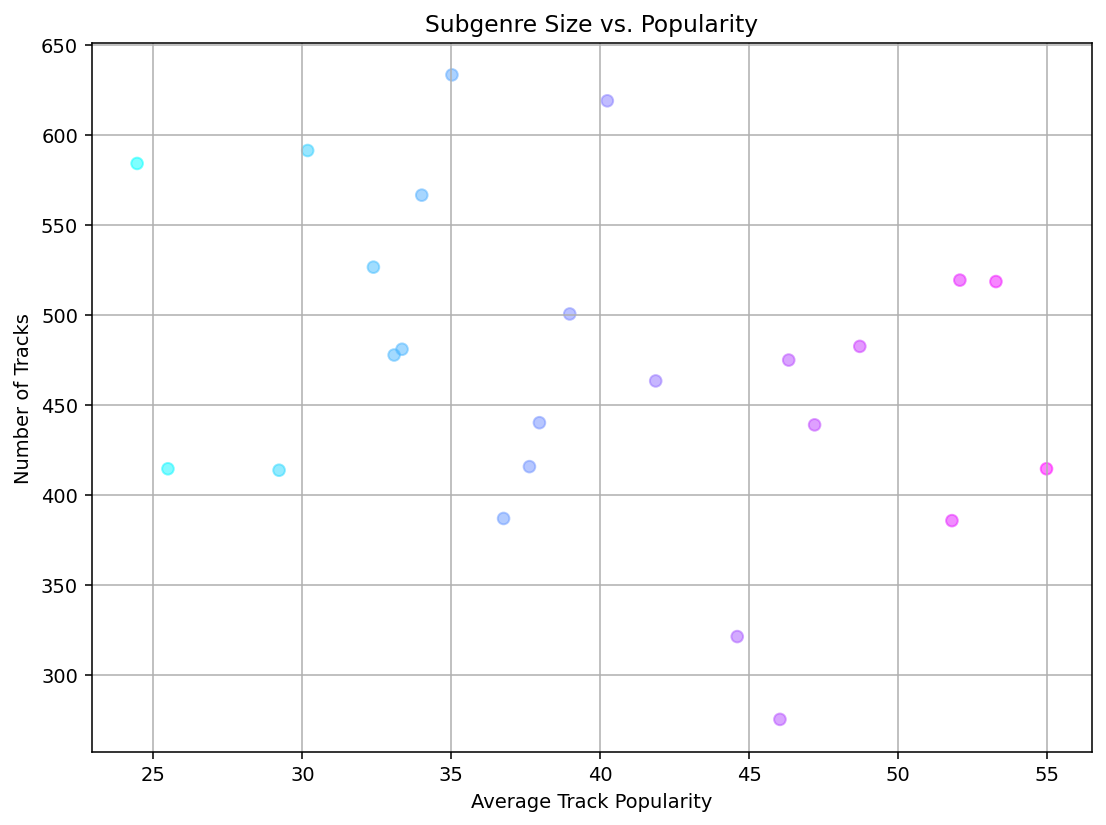

In [44]:
# Bubble chart of subgenre size vs. average popularity
sql = """
SELECT playlist_subgenre,
    COUNT(*) AS n,
    AVG(track_popularity)::float AS avg_pop
FROM staging_tracks
WHERE playlist_subgenre IS NOT NULL AND playlist_subgenre <> ''
GROUP BY playlist_subgenre
HAVING COUNT(*) >= 100;
"""
df = q(sql)

plt.figure(figsize=(8,6))
plt.scatter(df['avg_pop'], df['n']/5, alpha=0.5, c=df['avg_pop'], cmap='cool')
plt.title('Subgenre Size vs. Popularity')
plt.xlabel('Average Track Popularity')
plt.ylabel('Number of Tracks')
plt.tight_layout()
plt.savefig('../figures/subgenre_size_vs_popularity_bubble.png', bbox_inches='tight')
plt.show()

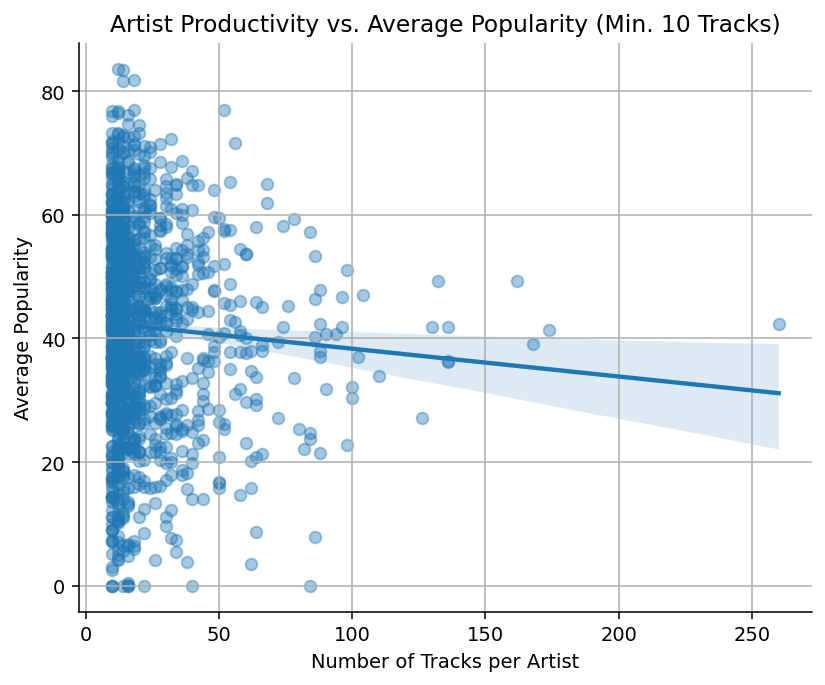

In [48]:
# Artist productivity vs. average track popularity
sql = """
WITH agg AS (
    SELECT track_artist, COUNT(*) AS n, AVG(track_popularity)::float AS avg_pop
    FROM staging_tracks
    WHERE track_artist IS NOT NULL AND track_artist <> ''
    GROUP BY track_artist
)
SELECT * FROM agg WHERE n >= 10;
"""
df = q(sql)

sns.lmplot(
    data=df,
    x='n',
    y='avg_pop',
    height=5,
    aspect=1.2,
    scatter_kws={'alpha':0.4}
    )
plt.title('Artist Productivity vs. Average Popularity (Min. 10 Tracks)')
plt.xlabel('Number of Tracks per Artist')
plt.ylabel('Average Popularity')
plt.tight_layout()
plt.savefig('../figures/artist_productivity_vs_popularity.png', bbox_inches='tight')
plt.show()

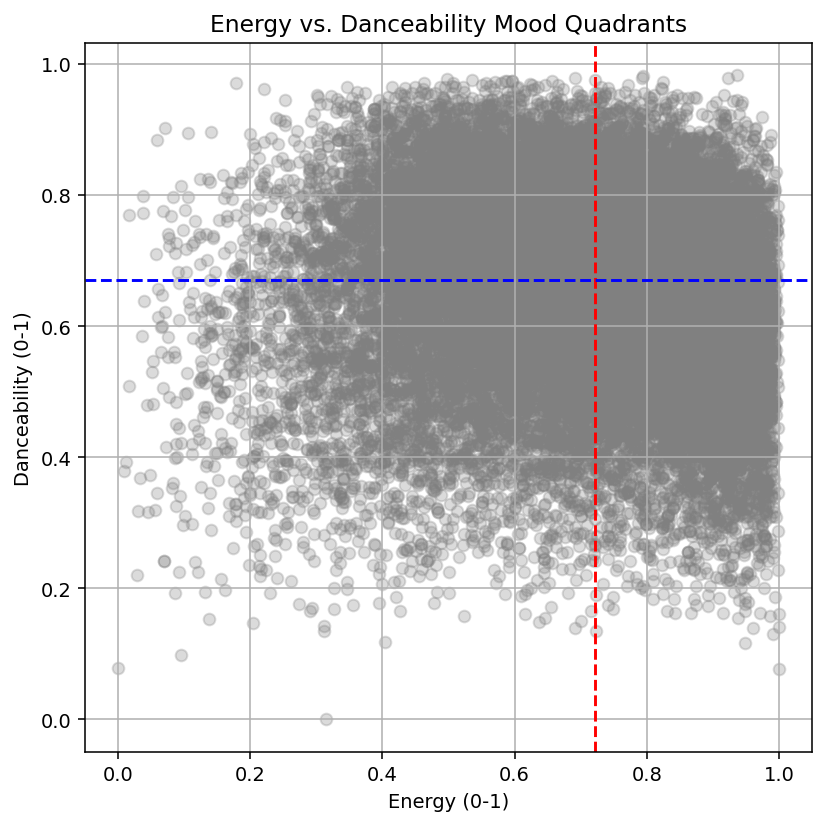

In [49]:
# Energy vs. Danceability Mood Quadrants
sql = """
SELECT danceability, energy, track_popularity
FROM staging_tracks
WHERE danceability IS NOT NULL AND energy IS NOT NULL;
"""
df = q(sql)

d_t = df['danceability'].median()
e_t = df['energy'].median()

plt.figure(figsize=(6,6))
plt.scatter(df['energy'], df['danceability'], alpha=0.15, color='gray')
plt.axvline(e_t, color='red', linestyle='--', label='Median Energy')
plt.axhline(d_t, color='blue', linestyle='--', label='Median Danceability')
plt.title("Energy vs. Danceability Mood Quadrants")
plt.xlabel("Energy (0-1)")
plt.ylabel("Danceability (0-1)")
plt.tight_layout()
plt.savefig("../figures/energy_danceability_quadrants.png", bbox_inches="tight")
plt.show()

C:\Users\David\AppData\Local\Temp\ipykernel_30756\421890597.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=pd.cut(df['n_tracks'], bins=[10,25,50,100,200]), y='avg_popularity', inner='box', palette='cool')


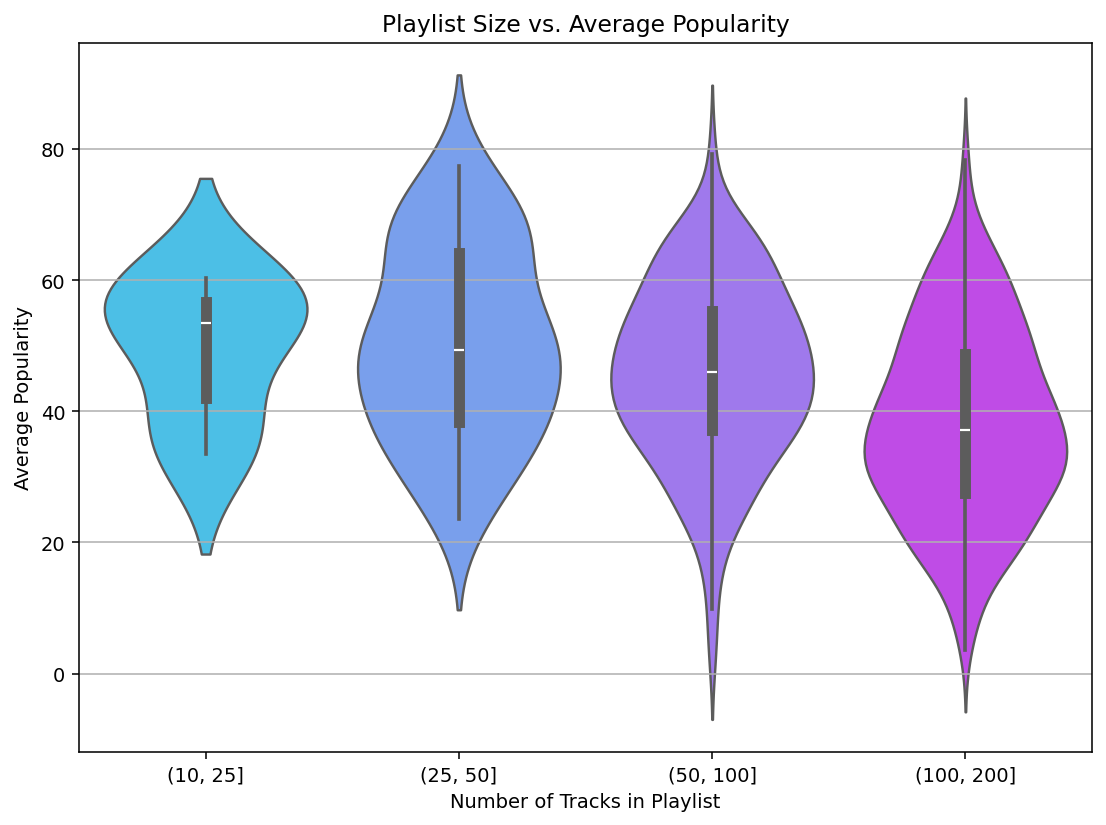

In [54]:
# Playlist size vs. average track popularity violin plot
sql = """
SELECT playlist_id, playlist_name,
    COUNT(*) AS n_tracks,
    AVG(track_popularity)::float AS avg_popularity
FROM staging_tracks
GROUP BY playlist_id, playlist_name
HAVING COUNT(*) >= 20;
"""
df = q(sql)

plt.figure(figsize=(8,6))
sns.violinplot(data=df, x=pd.cut(df['n_tracks'], bins=[10,25,50,100,200]), y='avg_popularity', inner='box', palette='cool')
plt.title('Playlist Size vs. Average Popularity')
plt.xlabel('Number of Tracks in Playlist')
plt.ylabel('Average Popularity')
plt.tight_layout()
plt.savefig('../figures/playlist_size_vs_popularity_violin.png', bbox_inches='tight')
plt.show()

In [1]:
insights = [
    "Energy and loudness track best with popularity; tempo alone doesn’t explain much.",
    "Top 5% ‘hits’ tend to be a bit faster, louder, more energetic/positive.",
    "Instrumentals are less popular on average, but have strong niches.",
    "Prolific artists don’t automatically score higher: quality > quantity.",
    "Playlists around 25–100 tracks look like the sweet spot for average popularity.",
]
print("What I learned:\n" + "\n".join(" • " + x for x in insights))


What I learned:
 • Energy and loudness track best with popularity; tempo alone doesn’t explain much.
 • Top 5% ‘hits’ tend to be a bit faster, louder, more energetic/positive.
 • Instrumentals are less popular on average, but have strong niches.
 • Prolific artists don’t automatically score higher: quality > quantity.
 • Playlists around 25–100 tracks look like the sweet spot for average popularity.
